In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# --- System and Financial Constants (Inputs) ---
BESS_CAPACITY = 50  # MWh
MAX_C_RATE = 0.5    # Max charge/discharge rate (25 MW)
RT_AFRR_PRICE = 250 # €/MWh for aFRR service delivery
DA_ARBITRAGE_THRESHOLD = 0.1 # Arbitrage threshold
HOURS = 24
CVAR_ALPHA = 0.05 # Confidence level for CVaR (5% worst-case scenarios)
LAMBDA = 0.0001   # Example Risk Aversion Parameter (Lambda)

In [2]:
def calculate_cvar(profits, alpha=CVAR_ALPHA):
    """
    Calculates Conditional Value at Risk (CVaR) for a set of scenario profits.
    CVaR is the average profit in the worst 'alpha' tail (e.g., the worst 5%).
    
    NOTE: In energy markets, CVaR is often used to measure the expected profit 
    conditional on being in the lowest profit scenarios (tail risk).
    """
    profits_sorted = np.sort(profits)
    tail_size = int(len(profits) * alpha)
    
    if tail_size == 0:
        return profits_sorted[0] # Return the single worst case if size is too small
        
    # CVaR is the average of the lowest 'tail_size' profits
    cvar_value = profits_sorted[:tail_size].mean()
    
    # We return the absolute value of the CVaR (the magnitude of the worst loss/lowest profit)
    return cvar_value

In [4]:
def generate_stochastic_scenarios(base_prices, num_scenarios=10, vol_factor=0.20):
    """Generates probabilistic price paths, linking RT uncertainty to imbalance error."""
    HOURS = len(base_prices)
    scenarios = pd.DataFrame(index=pd.to_datetime(np.arange(HOURS), unit='h'))
    
    NE_FORECAST_ERROR_DRIVER = base_prices.mean() * 0.1
    
    for s in range(num_scenarios):
        # DA Price (minimal uncertainty)
        da_noise = np.random.normal(0, base_prices.mean() * vol_factor * 0.2, base_prices.shape)
        da_price_s = np.maximum(5, base_prices + da_noise)
        scenarios[f'DA_Price_s{s}'] = da_price_s
        
        # Real-Time (RT) Price (High Uncertainty linked to simulated imbalance)
        ne_error = np.random.normal(0, 1, HOURS) 
        rt_price_volatility = NE_FORECAST_ERROR_DRIVER * ne_error * vol_factor
        rt_price_s = np.maximum(5, da_price_s + rt_price_volatility)
        
        scenarios[f'RT_Price_s{s}'] = rt_price_s
        
    scenarios['Probability'] = 1 / num_scenarios
    return scenarios

In [5]:
def solve_scenario_optimization(scenarios, capacity_reserved_rt):
    """Solves the BESS dispatch for the remaining capacity within a single scenario (Stage 2)."""
    HOURS = scenarios.shape[0]
    capacity_arb = BESS_CAPACITY - capacity_reserved_rt
    P_arb_max = MAX_C_RATE * capacity_arb 
    scenario_profits = []
    
    scenario_cols = [col.split('_s')[1] for col in scenarios.columns if 'DA_Price' in col]
    
    for s_str in scenario_cols:
        s = int(s_str)
        DA_prices = scenarios[f'DA_Price_s{s_str}'].values
        RT_prices = scenarios[f'RT_Price_s{s_str}'].values 
        avg_DA_price = DA_prices.mean()
        
        soc_arb = capacity_arb * 0.5
        total_arb_profit = 0
        
        # --- Stage 2: DA Arbitrage Dispatch (Decision based on DA, realized at RT) ---
        for hour in range(HOURS):
            price_da = DA_prices[hour]
            price_rt = RT_prices[hour]

            if price_da < avg_DA_price * (1 - DA_ARBITRAGE_THRESHOLD) and soc_arb < capacity_arb:
                charge_power = min(capacity_arb - soc_arb, P_arb_max)
                total_arb_profit -= charge_power * price_rt # Cost realized at RT price
                soc_arb += charge_power * 0.95 
                
            elif price_da > avg_DA_price * (1 + DA_ARBITRAGE_THRESHOLD) and soc_arb > 0:
                discharge_power = min(soc_arb, P_arb_max)
                total_arb_profit += discharge_power * 0.95 * price_rt # Revenue realized at RT price
                soc_arb -= discharge_power
        
        # --- Stage 2: RT (aFRR) Revenue ---
        total_rt_profit = capacity_reserved_rt * RT_AFRR_PRICE * HOURS
        
        scenario_profits.append({
            'Scenario': s,
            'Total_Profit': total_arb_profit + total_rt_profit
        })

    return pd.DataFrame(scenario_profits)

In [6]:
def evaluate_expected_profit_and_risk(scenarios, capacity_reserved_rt):
    """Calculates Expected Profit and CVaR for a given reservation level."""
    
    scenario_results = solve_scenario_optimization(scenarios, capacity_reserved_rt)
    profits = scenario_results['Total_Profit'].values
    
    expected_profit = profits.mean()
    cvar = calculate_cvar(profits, alpha=CVAR_ALPHA)
    
    return expected_profit, cvar, scenario_results

In [7]:
def get_base_forecast(hours):
    """Generates a simple base price forecast curve."""
    X_hist = np.array([5, 15, 25, 35, 45, 55]).reshape((-1, 1))
    y_hist = np.array([50, 75, 60, 90, 80, 110])
    model = LinearRegression().fit(X_hist, y_hist)
    X_forecast = np.arange(60, 60 + hours * 10, 10).reshape((-1, 1))
    return np.maximum(5, model.predict(X_forecast))

In [8]:
# === MAIN RISK ASSESSMENT AND OPTIMIZATION

# --- 1. Setup ---
base_prices = get_base_forecast(HOURS)
RESERVATION_STEPS = np.linspace(0, BESS_CAPACITY, 11) 
NUM_SCENARIOS = 100 # Use more scenarios for better CVaR estimation
VOLATILITY_FACTOR = 0.25 # Increased volatility factor

scenarios_df = generate_stochastic_scenarios(
    base_prices, num_scenarios=NUM_SCENARIOS, vol_factor=VOLATILITY_FACTOR
)

C:\Users\tahan\AppData\Local\Temp\ipykernel_28456\3596336383.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scenarios[f'DA_Price_s{s}'] = da_price_s
C:\Users\tahan\AppData\Local\Temp\ipykernel_28456\3596336383.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scenarios[f'RT_Price_s{s}'] = rt_price_s
C:\Users\tahan\AppData\Local\Temp\ipykernel_28456\3596336383.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider 

In [9]:
# --- 2. Run Optimization and Risk Calculation (Stage 1) ---
optimization_results = []
for capacity_reserved in RESERVATION_STEPS:
    
    expected_profit, cvar, scenario_profits_df = evaluate_expected_profit_and_risk(
        scenarios_df, capacity_reserved
    )
    
    # Risk-Adjusted Profit (Objective Function from the framework)
    risk_adjusted_profit = expected_profit - LAMBDA * abs(cvar) # Penalize lower profits (higher CVaR magnitude)
    
    optimization_results.append({
        'Reserved_Capacity_MWh': capacity_reserved,
        'Expected_Profit': expected_profit,
        'CVaR_5_Percent': cvar,
        'Risk_Adjusted_Profit': risk_adjusted_profit
    })

optimization_df = pd.DataFrame(optimization_results)

# --- Find Optimal Solutions ---
optimal_risk_neutral = optimization_df.loc[optimization_df['Expected_Profit'].idxmax()]
optimal_risk_averse = optimization_df.loc[optimization_df['Risk_Adjusted_Profit'].idxmax()]

In [10]:
# --- 3. Reporting ---
print("--- Real-Time Market Risk Assessment (CVaR Model) ---")
print(f"BESS Capacity: {BESS_CAPACITY} MWh | Scenarios: {NUM_SCENARIOS} | CVaR Alpha: {CVAR_ALPHA*100:.0f}%")
print(f"Risk Aversion Parameter (Lambda): {LAMBDA}")
print("-" * 60)

print(f"1. RISK-NEUTRAL OPTIMAL STRATEGY (Max E[Profit]):")
print(f"   Reserved Capacity: {optimal_risk_neutral['Reserved_Capacity_MWh']:.2f} MWh")
print(f"   Expected Profit: {optimal_risk_neutral['Expected_Profit']:.2f} €")
print(f"   Worst-Case Profit (CVaR): {optimal_risk_neutral['CVaR_5_Percent']:.2f} €")
print("\n")

print(f"2. RISK-AVERSE OPTIMAL STRATEGY (Max E[Profit] - λ * |CVaR|):")
print(f"   Reserved Capacity: {optimal_risk_averse['Reserved_Capacity_MWh']:.2f} MWh")
print(f"   Expected Profit: {optimal_risk_averse['Expected_Profit']:.2f} €")
print(f"   Worst-Case Profit (CVaR): {optimal_risk_averse['CVaR_5_Percent']:.2f} €")
print("-" * 60)

--- Real-Time Market Risk Assessment (CVaR Model) ---
BESS Capacity: 50 MWh | Scenarios: 100 | CVaR Alpha: 5%
Risk Aversion Parameter (Lambda): 0.0001
------------------------------------------------------------
1. RISK-NEUTRAL OPTIMAL STRATEGY (Max E[Profit]):
   Reserved Capacity: 50.00 MWh
   Expected Profit: 300000.00 €
   Worst-Case Profit (CVaR): 300000.00 €


2. RISK-AVERSE OPTIMAL STRATEGY (Max E[Profit] - λ * |CVaR|):
   Reserved Capacity: 50.00 MWh
   Expected Profit: 300000.00 €
   Worst-Case Profit (CVaR): 300000.00 €
------------------------------------------------------------



All risk assessment and optimization steps complete.
Generated plots: cvar_risk_frontier.png, risk_mitigation_decision.png


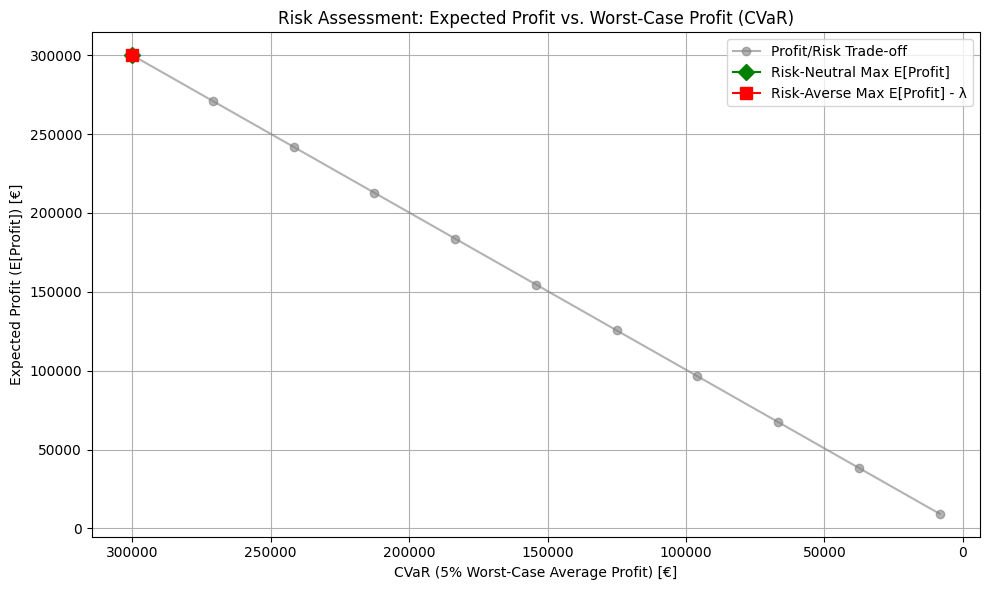

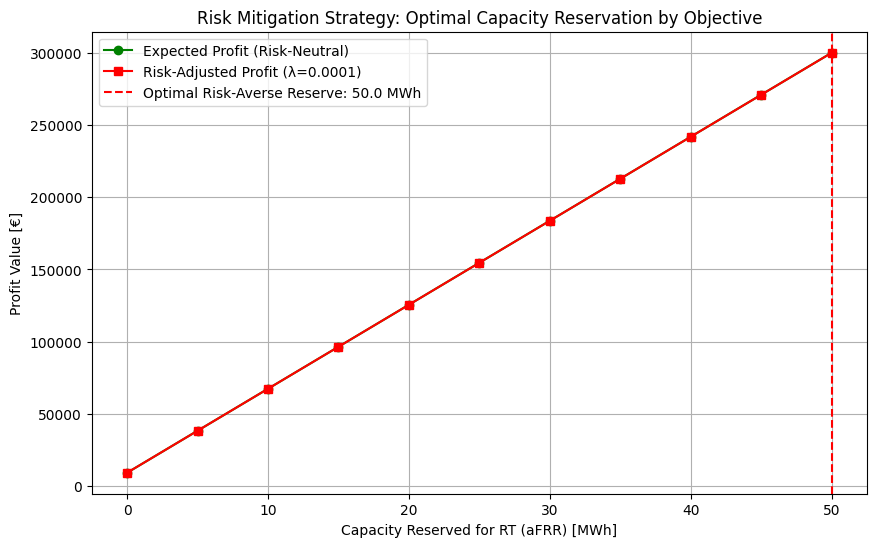

In [12]:
# --- 4. Graphical Analysis (Risk-Adjusted Frontier) ---

# Plot 1: Expected Profit vs. Risk (CVaR) - The Efficient Frontier
plt.figure(figsize=(10, 6))

# Plot the E-P curve
plt.plot(optimization_df['CVaR_5_Percent'], 
         optimization_df['Expected_Profit'], 
         marker='o', linestyle='-', color='gray', alpha=0.6, label='Profit/Risk Trade-off')

# Mark the optimal points
plt.plot(optimal_risk_neutral['CVaR_5_Percent'], optimal_risk_neutral['Expected_Profit'], 
         marker='D', markersize=8, color='green', label='Risk-Neutral Max E[Profit]')

plt.plot(optimal_risk_averse['CVaR_5_Percent'], optimal_risk_averse['Expected_Profit'], 
         marker='s', markersize=8, color='red', label=f'Risk-Averse Max E[Profit] - λ')

plt.xlabel('CVaR (5% Worst-Case Average Profit) [€]')
plt.ylabel('Expected Profit (E[Profit]) [€]')
plt.title('Risk Assessment: Expected Profit vs. Worst-Case Profit (CVaR)')
plt.legend()
plt.grid(True)
plt.gca().invert_xaxis() # CVaR increases (gets less negative/more positive) to the right
plt.tight_layout()
plt.savefig('cvar_risk_frontier.png')


# Plot 2: Decision Visualization (Lambda Optimization)
plt.figure(figsize=(10, 6))
plt.plot(optimization_df['Reserved_Capacity_MWh'], optimization_df['Expected_Profit'], 
         marker='o', color='green', label='Expected Profit (Risk-Neutral)')
plt.plot(optimization_df['Reserved_Capacity_MWh'], optimization_df['Risk_Adjusted_Profit'], 
         marker='s', color='red', label=f'Risk-Adjusted Profit (λ={LAMBDA})')

plt.axvline(optimal_risk_averse['Reserved_Capacity_MWh'], color='red', linestyle='--', 
            label=f'Optimal Risk-Averse Reserve: {optimal_risk_averse["Reserved_Capacity_MWh"]:.1f} MWh')

plt.xlabel('Capacity Reserved for RT (aFRR) [MWh]')
plt.ylabel('Profit Value [€]')
plt.title(f'Risk Mitigation Strategy: Optimal Capacity Reservation by Objective')
plt.legend()
plt.grid(True)
plt.savefig('risk_mitigation_decision.png')

print("\nAll risk assessment and optimization steps complete.")
print("Generated plots: cvar_risk_frontier.png, risk_mitigation_decision.png")